In [234]:
import pandas as pd
import sqlite3

Подключение к БД

In [235]:
db = sqlite3.connect('../data/checking-logs.sqlite')

In [236]:
query = '''
SELECT uid, timestamp
FROM checker
WHERE uid LIKE 'user_%'
'''
commits = pd.io.sql.read_sql(query, db, parse_dates=['timestamp'])

Создадим отдельные колонки weekday, day и hour

In [237]:
commits['weekday'] = commits['timestamp'].dt.dayofweek
commits['day'] = commits['timestamp'].dt.day
commits['hour'] = commits['timestamp'].dt.hour

С помощью weekday определим является ли день недели выходным или рабочим днем

In [238]:
commits['is_weekend'] = commits['weekday'] >= 5
commits

,uid,timestamp,weekday,day,hour,is_weekend
0,user_4,2020-04-17 05:19:02.744528,4,17,5,False
1,user_4,2020-04-17 05:22:35.249331,4,17,5,False
2,user_4,2020-04-17 05:22:45.549397,4,17,5,False
3,user_4,2020-04-17 05:34:14.691200,4,17,5,False
4,user_4,2020-04-17 05:34:24.422370,4,17,5,False
...,...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,3,21,20,False
3203,user_1,2020-05-21 20:22:41.785725,3,21,20,False
3204,user_1,2020-05-21 20:22:41.877806,3,21,20,False
3205,user_1,2020-05-21 20:37:00.129678,3,21,20,False


Сгруппируем коммиты сначала по is_weekend day hour. После группировки данные разбиваются на группы по уникальным комбинациям значений этих столбцов.

Для каждой группы подсчитывается количество ненулевых значений в каждом столбце (по умолчанию).
В результате получается таблица, где для каждой комбинации is_weekend, day, и hour указывается количество записей.

In [239]:
count_commits = commits.groupby(['is_weekend', 'day', 'hour']).count()
avg_commits = count_commits.groupby(
    ['is_weekend', 'hour']).mean()['uid'].reset_index()
avg_commits

,is_weekend,hour,uid
0,False,0,3.000000
1,False,3,2.000000
2,False,5,7.500000
3,False,6,1.500000
4,False,7,5.166667
5,False,8,3.700000
6,False,9,6.000000
7,False,10,13.200000
8,False,11,6.769231
9,False,12,7.181818


Создание сводной таблицы для того, чтобы было проще визуализировать

In [240]:
pivot_table = pd.pivot(avg_commits,
                       values='uid',
                       index='hour',
                       columns='is_weekend')
pivot_table

is_weekend,False,True
hour,,
0,3.000000,2.000000
1,NaN,6.000000
3,2.000000,1.000000
5,7.500000,2.000000
6,1.500000,NaN
7,5.166667,4.000000
8,3.700000,7.000000
9,6.000000,3.666667
10,13.200000,7.000000


Для корректных и читаемых подписей заменю значения переменной is_weekend

In [241]:
pivot_table.columns = pivot_table.columns.map({True: 'weekend', False: 'working_day'})

Создание гистограмм 

array([<Axes: title={'center': 'working_day'}, xlabel='hour'>,
       <Axes: title={'center': 'weekend'}, xlabel='hour'>], dtype=object)

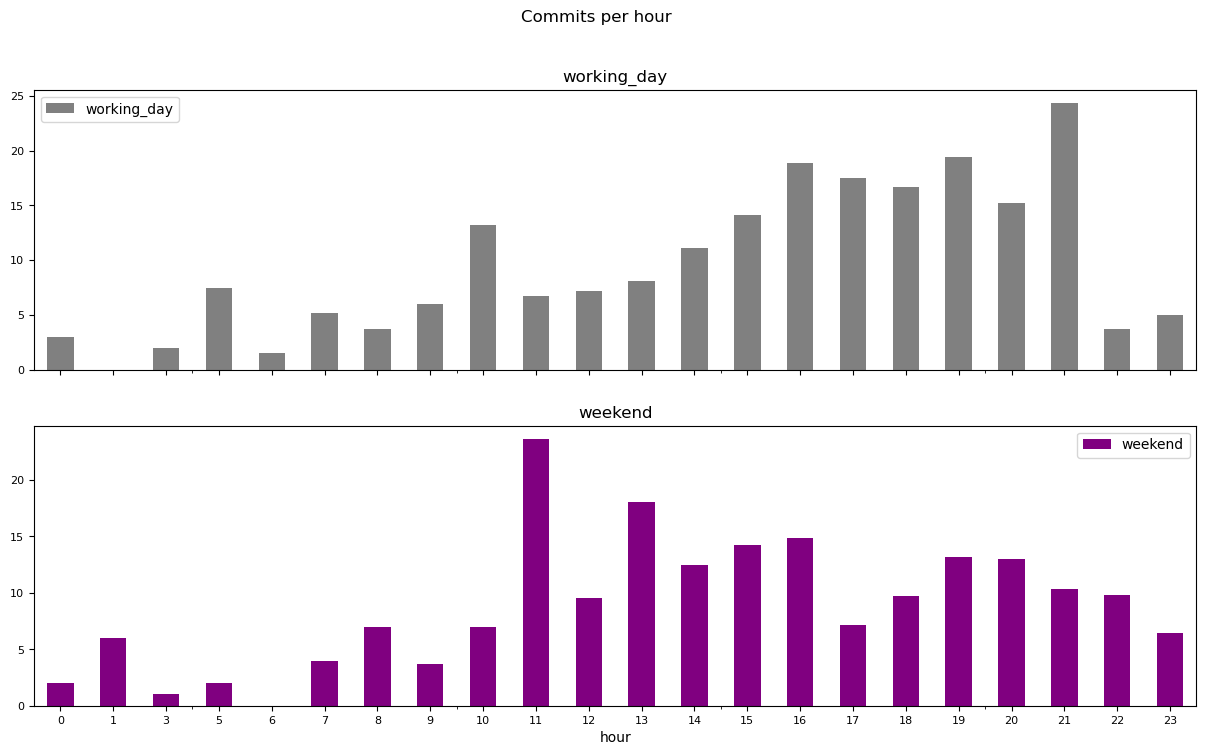

In [247]:
pivot_table.plot(kind='bar',
                      figsize=(15, 8),
                      title='Commits per hour',
                      rot=0,
                      fontsize=8,
                      color = ['gray', 'purple'],
                      subplots=True)

## «Отличается ли динамика в рабочие и выходные дни?» — для ответа включите час, когда количество фиксаций наибольшее в рабочие дни, и час, когда оно наибольшее в выходные.

Да, отличается

In [243]:
max_working_hour = pivot_table[pivot_table['working_day'] == pivot_table['working_day'].max()]
max_working_hour

is_weekend,working_day,weekend
hour,,
21,24.333333,10.285714


In [244]:
max_weekend_hour = pivot_table[pivot_table['weekend'] == pivot_table['weekend'].max()]
max_weekend_hour

is_weekend,working_day,weekend
hour,,
11,6.769231,23.6


In [245]:
db.close()